In [1]:
# prerequisites
import os
import torch
import time
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from tqdm import tqdm

from utils import *
from models import MNIST_SITE

# Device configuration
torch.manual_seed(0)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [2]:
batch_size = 256
model_path = './models/MNIST'
n_epoch = 200
n_show = 1

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size, shuffle=False)

In [3]:
site = MNIST_SITE().to(device)
print(f'Models are properly built! There are totally {get_n_params(site)} parameters.')

optimizer = optim.Adam(site.parameters(), lr = 1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [200], gamma = 0.5)

celoss = nn.CrossEntropyLoss()
bceloss = nn.BCELoss()

Models are properly built! There are totally 1365472 parameters.


235it [00:14, 16.60it/s]


epoch: 1, loss: 1.230/7.449, train_acc: 0.6122, test_acc: 0.8104, time: 15.71


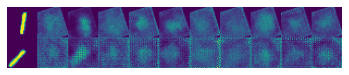

235it [00:14, 16.43it/s]


epoch: 2, loss: 0.524/6.378, train_acc: 0.8417, test_acc: 0.8596, time: 15.87


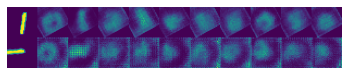

235it [00:14, 16.52it/s]


epoch: 3, loss: 0.403/6.144, train_acc: 0.8793, test_acc: 0.8883, time: 15.86


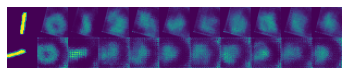

235it [00:13, 16.97it/s]


epoch: 4, loss: 0.337/6.042, train_acc: 0.8992, test_acc: 0.9206, time: 15.39


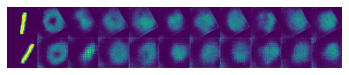

235it [00:14, 16.53it/s]


epoch: 5, loss: 0.299/5.949, train_acc: 0.9115, test_acc: 0.9131, time: 15.80


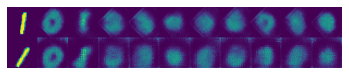

235it [00:13, 16.83it/s]


epoch: 6, loss: 0.274/5.935, train_acc: 0.9202, test_acc: 0.9319, time: 15.59


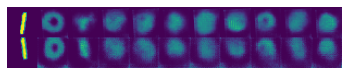

235it [00:14, 16.44it/s]


epoch: 7, loss: 0.253/5.905, train_acc: 0.9253, test_acc: 0.9231, time: 15.83


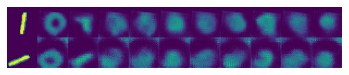

235it [00:15, 15.65it/s]


epoch: 8, loss: 0.236/5.809, train_acc: 0.9296, test_acc: 0.9344, time: 16.58


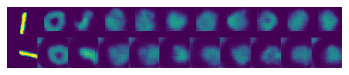

235it [00:14, 16.20it/s]


epoch: 9, loss: 0.227/5.856, train_acc: 0.9329, test_acc: 0.9382, time: 16.12


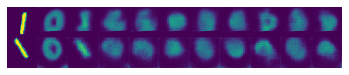

235it [00:14, 16.64it/s]


epoch: 10, loss: 0.220/5.846, train_acc: 0.9356, test_acc: 0.9421, time: 15.69


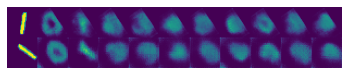

235it [00:14, 16.09it/s]


epoch: 11, loss: 0.211/5.842, train_acc: 0.9379, test_acc: 0.9467, time: 16.18


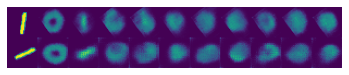

235it [00:14, 15.89it/s]


epoch: 12, loss: 0.201/5.816, train_acc: 0.9401, test_acc: 0.9447, time: 16.39


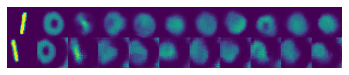

235it [00:14, 15.97it/s]


epoch: 13, loss: 0.196/5.865, train_acc: 0.9424, test_acc: 0.9475, time: 16.25


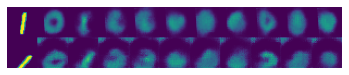

235it [00:14, 15.89it/s]


epoch: 14, loss: 0.191/5.850, train_acc: 0.9432, test_acc: 0.9540, time: 16.35


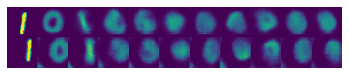

235it [00:13, 17.51it/s]


epoch: 15, loss: 0.184/5.870, train_acc: 0.9468, test_acc: 0.9504, time: 15.00


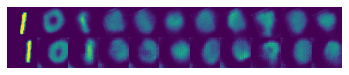

235it [00:14, 16.73it/s]


epoch: 16, loss: 0.184/5.827, train_acc: 0.9454, test_acc: 0.9528, time: 15.61


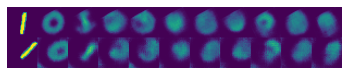

235it [00:14, 15.68it/s]


epoch: 17, loss: 0.173/5.790, train_acc: 0.9493, test_acc: 0.9518, time: 16.54


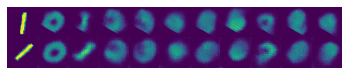

235it [00:14, 16.46it/s]


epoch: 18, loss: 0.179/5.820, train_acc: 0.9472, test_acc: 0.9526, time: 15.88


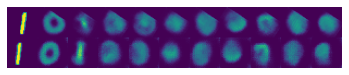

235it [00:14, 16.48it/s]


epoch: 19, loss: 0.173/5.821, train_acc: 0.9508, test_acc: 0.9514, time: 15.81


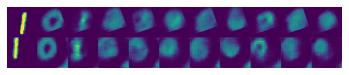

235it [00:13, 16.87it/s]


epoch: 20, loss: 0.165/5.785, train_acc: 0.9515, test_acc: 0.9550, time: 15.51


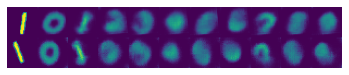

235it [00:14, 16.26it/s]


epoch: 21, loss: 0.159/5.856, train_acc: 0.9533, test_acc: 0.9549, time: 16.11


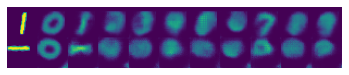

235it [00:14, 16.63it/s]


epoch: 22, loss: 0.167/5.783, train_acc: 0.9519, test_acc: 0.9613, time: 15.65


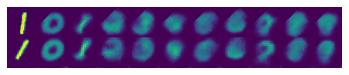

235it [00:14, 16.39it/s]


epoch: 23, loss: 0.162/5.781, train_acc: 0.9528, test_acc: 0.9583, time: 15.90


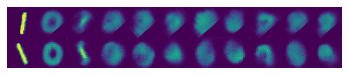

235it [00:14, 16.42it/s]


epoch: 24, loss: 0.157/5.783, train_acc: 0.9535, test_acc: 0.9587, time: 15.89


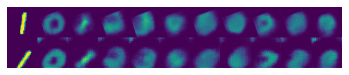

235it [00:14, 16.30it/s]


epoch: 25, loss: 0.152/5.791, train_acc: 0.9552, test_acc: 0.9563, time: 15.99


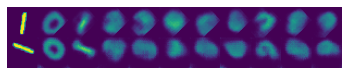

235it [00:13, 17.01it/s]


epoch: 26, loss: 0.154/5.802, train_acc: 0.9547, test_acc: 0.9598, time: 15.34


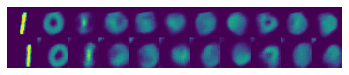

235it [00:14, 16.45it/s]


epoch: 27, loss: 0.154/5.796, train_acc: 0.9548, test_acc: 0.9631, time: 15.93


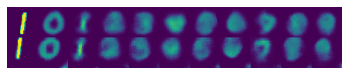

235it [00:14, 16.69it/s]


epoch: 28, loss: 0.142/5.730, train_acc: 0.9576, test_acc: 0.9616, time: 15.67


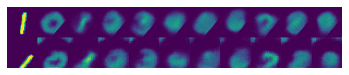

235it [00:14, 16.38it/s]


epoch: 29, loss: 0.148/5.777, train_acc: 0.9568, test_acc: 0.9576, time: 15.92


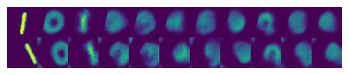

235it [00:14, 16.37it/s]


epoch: 30, loss: 0.142/5.768, train_acc: 0.9580, test_acc: 0.9626, time: 16.00


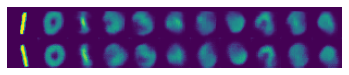

235it [00:14, 15.96it/s]


epoch: 31, loss: 0.137/5.768, train_acc: 0.9603, test_acc: 0.9624, time: 16.26


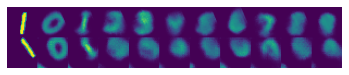

235it [00:14, 15.98it/s]


epoch: 32, loss: 0.142/5.793, train_acc: 0.9595, test_acc: 0.9609, time: 16.23


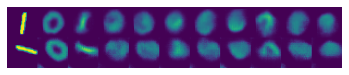

235it [00:14, 16.63it/s]


epoch: 33, loss: 0.140/5.804, train_acc: 0.9594, test_acc: 0.9608, time: 15.74


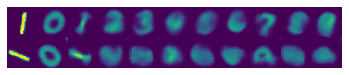

235it [00:14, 15.82it/s]


epoch: 34, loss: 0.136/5.776, train_acc: 0.9602, test_acc: 0.9652, time: 16.40


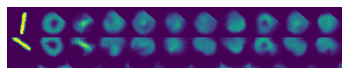

235it [00:14, 16.55it/s]


epoch: 35, loss: 0.135/5.753, train_acc: 0.9610, test_acc: 0.9580, time: 15.76


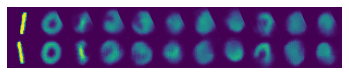

235it [00:14, 16.76it/s]


epoch: 36, loss: 0.132/5.720, train_acc: 0.9617, test_acc: 0.9608, time: 15.65


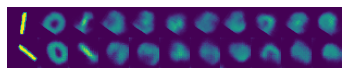

235it [00:14, 16.20it/s]


epoch: 37, loss: 0.134/5.737, train_acc: 0.9608, test_acc: 0.9637, time: 16.04


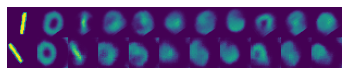

235it [00:13, 17.59it/s]


epoch: 38, loss: 0.133/5.761, train_acc: 0.9616, test_acc: 0.9650, time: 14.95


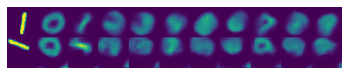

235it [00:14, 15.95it/s]


epoch: 39, loss: 0.128/5.766, train_acc: 0.9628, test_acc: 0.9685, time: 16.41


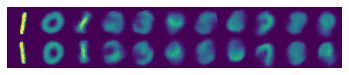

235it [00:14, 16.53it/s]


epoch: 40, loss: 0.127/5.742, train_acc: 0.9632, test_acc: 0.9644, time: 15.77


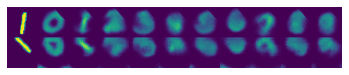

235it [00:13, 17.16it/s]


epoch: 41, loss: 0.126/5.753, train_acc: 0.9628, test_acc: 0.9699, time: 15.28


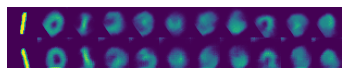

235it [00:14, 16.78it/s]


epoch: 42, loss: 0.129/5.710, train_acc: 0.9634, test_acc: 0.9663, time: 15.60


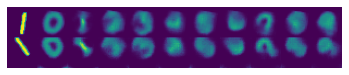

235it [00:14, 16.39it/s]


epoch: 43, loss: 0.125/5.714, train_acc: 0.9636, test_acc: 0.9674, time: 15.91


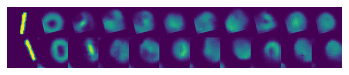

235it [00:13, 16.87it/s]


epoch: 44, loss: 0.125/5.756, train_acc: 0.9634, test_acc: 0.9699, time: 15.44


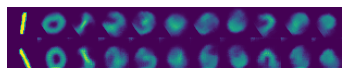

235it [00:15, 15.65it/s]


epoch: 45, loss: 0.123/5.724, train_acc: 0.9648, test_acc: 0.9672, time: 16.57


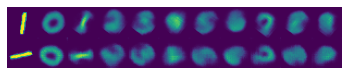

235it [00:12, 19.38it/s]


epoch: 46, loss: 0.119/5.731, train_acc: 0.9643, test_acc: 0.9705, time: 13.62


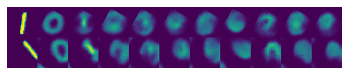

235it [00:12, 18.11it/s]


epoch: 47, loss: 0.119/5.755, train_acc: 0.9651, test_acc: 0.9675, time: 14.53


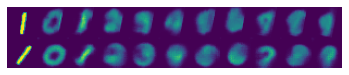

235it [00:15, 15.29it/s]


epoch: 48, loss: 0.115/5.760, train_acc: 0.9656, test_acc: 0.9706, time: 16.94


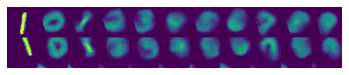

235it [00:12, 18.49it/s]


epoch: 49, loss: 0.120/5.740, train_acc: 0.9655, test_acc: 0.9699, time: 14.19


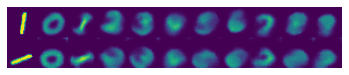

235it [00:13, 17.26it/s]


epoch: 50, loss: 0.119/5.732, train_acc: 0.9654, test_acc: 0.9678, time: 15.10


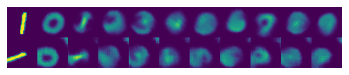

235it [00:14, 16.78it/s]


epoch: 51, loss: 0.119/5.745, train_acc: 0.9644, test_acc: 0.9674, time: 15.62


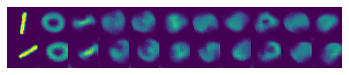

235it [00:14, 16.27it/s]


epoch: 52, loss: 0.117/5.744, train_acc: 0.9662, test_acc: 0.9685, time: 15.94


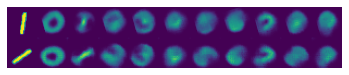

235it [00:14, 16.51it/s]


epoch: 53, loss: 0.112/5.750, train_acc: 0.9664, test_acc: 0.9692, time: 15.77


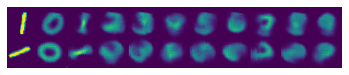

235it [00:14, 16.70it/s]


epoch: 54, loss: 0.114/5.731, train_acc: 0.9671, test_acc: 0.9717, time: 15.59


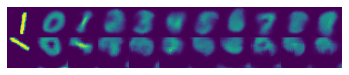

235it [00:13, 16.96it/s]


epoch: 55, loss: 0.110/5.701, train_acc: 0.9677, test_acc: 0.9669, time: 15.36


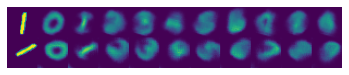

235it [00:12, 18.39it/s]


epoch: 56, loss: 0.112/5.756, train_acc: 0.9663, test_acc: 0.9668, time: 14.29


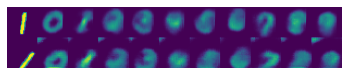

235it [00:13, 17.54it/s]


epoch: 57, loss: 0.109/5.732, train_acc: 0.9677, test_acc: 0.9704, time: 15.01


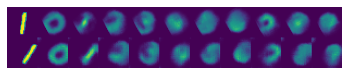

235it [00:14, 16.71it/s]


epoch: 58, loss: 0.110/5.740, train_acc: 0.9680, test_acc: 0.9705, time: 15.65


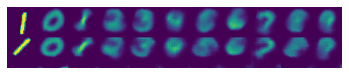

235it [00:13, 17.10it/s]


epoch: 59, loss: 0.111/5.738, train_acc: 0.9676, test_acc: 0.9725, time: 15.33


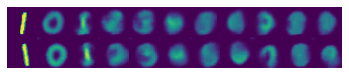

235it [00:13, 16.89it/s]


epoch: 60, loss: 0.106/5.724, train_acc: 0.9697, test_acc: 0.9705, time: 15.51


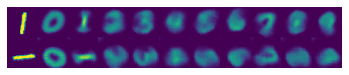

235it [00:13, 16.90it/s]


epoch: 61, loss: 0.108/5.704, train_acc: 0.9692, test_acc: 0.9673, time: 15.52


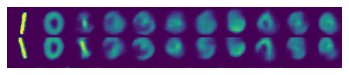

235it [00:14, 16.74it/s]


epoch: 62, loss: 0.107/5.730, train_acc: 0.9693, test_acc: 0.9703, time: 15.61


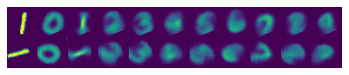

235it [00:13, 17.25it/s]


epoch: 63, loss: 0.107/5.727, train_acc: 0.9692, test_acc: 0.9715, time: 15.23


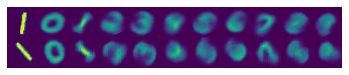

235it [00:13, 16.84it/s]


epoch: 64, loss: 0.107/5.719, train_acc: 0.9696, test_acc: 0.9688, time: 15.51


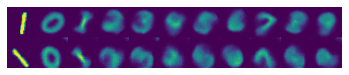

235it [00:14, 16.18it/s]


epoch: 65, loss: 0.105/5.743, train_acc: 0.9697, test_acc: 0.9729, time: 16.12


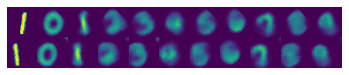

235it [00:14, 16.14it/s]


epoch: 66, loss: 0.103/5.718, train_acc: 0.9699, test_acc: 0.9718, time: 16.19


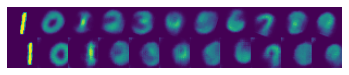

235it [00:14, 15.78it/s]


epoch: 67, loss: 0.108/5.710, train_acc: 0.9688, test_acc: 0.9688, time: 16.44


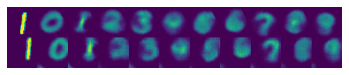

235it [00:14, 16.16it/s]


epoch: 68, loss: 0.106/5.716, train_acc: 0.9687, test_acc: 0.9723, time: 16.08


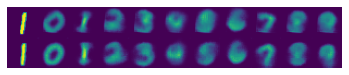

235it [00:13, 17.50it/s]


epoch: 69, loss: 0.106/5.741, train_acc: 0.9690, test_acc: 0.9720, time: 15.31


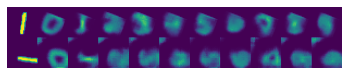

235it [00:14, 16.51it/s]


epoch: 70, loss: 0.106/5.718, train_acc: 0.9695, test_acc: 0.9712, time: 15.80


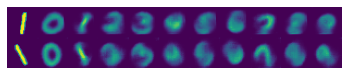

235it [00:13, 17.25it/s]


epoch: 71, loss: 0.104/5.701, train_acc: 0.9706, test_acc: 0.9721, time: 15.20


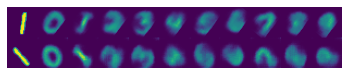

235it [00:14, 16.20it/s]


epoch: 72, loss: 0.107/5.729, train_acc: 0.9703, test_acc: 0.9705, time: 16.15


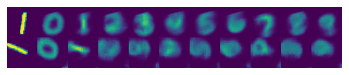

235it [00:14, 15.92it/s]


epoch: 73, loss: 0.105/5.721, train_acc: 0.9685, test_acc: 0.9718, time: 16.29


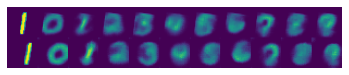

235it [00:14, 16.43it/s]


epoch: 74, loss: 0.105/5.744, train_acc: 0.9698, test_acc: 0.9726, time: 15.88


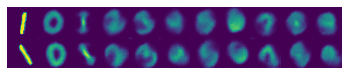

235it [00:14, 16.40it/s]


epoch: 75, loss: 0.099/5.663, train_acc: 0.9708, test_acc: 0.9729, time: 15.98


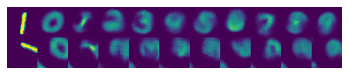

235it [00:14, 15.82it/s]


epoch: 76, loss: 0.099/5.702, train_acc: 0.9708, test_acc: 0.9748, time: 16.40


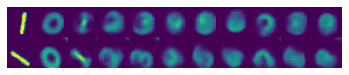

235it [00:13, 16.83it/s]


epoch: 77, loss: 0.098/5.700, train_acc: 0.9708, test_acc: 0.9720, time: 15.51


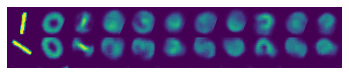

235it [00:14, 16.40it/s]


epoch: 78, loss: 0.100/5.708, train_acc: 0.9708, test_acc: 0.9750, time: 15.93


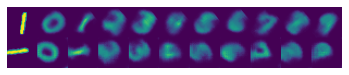

235it [00:14, 16.64it/s]


epoch: 79, loss: 0.100/5.703, train_acc: 0.9709, test_acc: 0.9739, time: 15.66


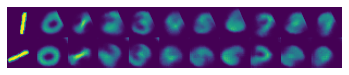

235it [00:13, 16.89it/s]


epoch: 80, loss: 0.099/5.697, train_acc: 0.9710, test_acc: 0.9708, time: 15.46


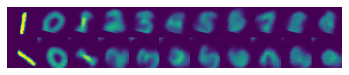

235it [00:14, 16.63it/s]


epoch: 81, loss: 0.096/5.742, train_acc: 0.9716, test_acc: 0.9721, time: 15.73


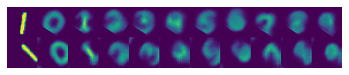

235it [00:14, 16.49it/s]


epoch: 82, loss: 0.097/5.717, train_acc: 0.9727, test_acc: 0.9750, time: 15.85


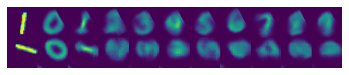

235it [00:14, 16.77it/s]


epoch: 83, loss: 0.097/5.635, train_acc: 0.9708, test_acc: 0.9697, time: 15.54


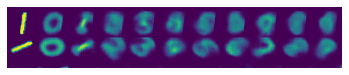

235it [00:14, 16.28it/s]


epoch: 84, loss: 0.096/5.709, train_acc: 0.9723, test_acc: 0.9725, time: 16.04


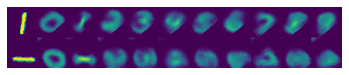

146it [00:08, 14.86it/s]

In [ ]:
for epoch in range(n_epoch):
    Loss_cls = []
    Loss_rec = []
    Loss_tar = []
    equality = 0
    start = time.time()
    
    # generate new prototypes
    prototype = get_prototype(train_loader)
    
    for batch_idx, (image, label) in tqdm(enumerate(train_loader)):
        
        site.train()
        
        optimizer.zero_grad()
        
        image = image.to(device)
        label = label.to(device)
        
        theta, gamma = get_theta(image.shape[0], get_reverse = True)
        t_image = transform(image, theta, dataset = 'MNIST')
        
        t_W, t_pred = site.get_explanation(t_image)
        t_W_t = transform_W(t_W, gamma, dataset = 'MNIST')
        
        # Classification loss
        loss_cls = celoss(t_pred, label)
        Loss_cls.append(loss_cls)
        
        # Reconstruction loss
        target = sample_prototype(prototype, label)
        loss_rec = 10*bceloss(t_W_t, target)
        Loss_rec.append(loss_rec.item())
        
        loss = loss_cls + loss_rec
        loss.backward()
        optimizer.step()
        
        equality += (t_pred.max(1)[1] == label).float().mean()
    
    train_accuracy = equality / (batch_idx + 1)
    scheduler.step()
    
    equality = 0
    for batch_idx, (image, label) in enumerate(test_loader):
        
        site.eval()
        
        image = image.to(device)
        label = label.to(device)
        
        theta, gamma = get_theta(image.shape[0], get_reverse = True)
        t_image = transform(image, theta, dataset = 'MNIST')
        
        t_W, t_pred = site.get_explanation(t_image)

        equality += (t_pred.max(1)[1] == label).float().mean()
        
    test_accuracy = equality / (batch_idx + 1)
    
    print('epoch: {}, loss: {:.3f}/{:.3f}, train_acc: {:.4f}, test_acc: {:.4f}, time: {:.2f}'.format(
        epoch + 1,
        torch.FloatTensor(Loss_cls).mean(),
        torch.FloatTensor(Loss_rec).mean(),
        train_accuracy,
        test_accuracy,
        time.time() - start))
    
    if n_epoch % n_show == 0:
        toshow1 = torch.cat([image[0], t_W_t[0].view(10,28,28)], dim = 0)
        toshow2 = torch.cat([t_image[0], t_W[0]], dim = 0)
        toshow = torch.cat([toshow1, toshow2], dim = 1)
        plot_process(toshow)